#**EE769 Introduction to Machine Learning**

#Programming Assignment – 3 : Deep Learning and Unsupervised Learning


**Name:** Prafull Pratap Bhosale

**Roll No.** 203010005


**Name:** Ojaswini Bhardwaj

**Roll No.** 213300011


# Q1: Convolutional Neural Networks

**Reference:**

Code in this assignment is heavily brought from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Still some code changes are done here and there in order to efficiently perform tasks given in the assignment

In [4]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [6]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -qq hymenoptera_data.zip

--2022-05-07 16:15:08--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.160.7, 13.224.160.39, 13.224.160.89, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.160.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  57.4MB/s    in 0.8s    

2022-05-07 16:15:09 (57.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



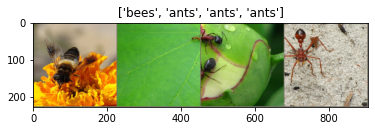

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_loss_over_epochs = np.zeros(num_epochs)
    val_acc_over_epochs = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # store validation loss and accuracy for further plotting
            if phase == 'val':
              val_loss_over_epochs[epoch] = epoch_loss
              val_acc_over_epochs[epoch] = epoch_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, val_loss_over_epochs, val_acc_over_epochs

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




# Q1 - Part d

Change the learning rate, momentum, and number of epochs at least three times to
see the net effect on final validation loss and accuracy and its speed of convergence.
https://pytorch.org/docs/stable/optim.html

In [ ]:
learning_rates = [0.0001, 0.001, 0.1] # Three values of learning rate
momentums = [0.2,0.5,0.9] # three values if momentum
num_epochs = [10,50,250] # three values for number of epochs

### Effect of learning rates

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6794 Acc: 0.5820
val Loss: 0.5842 Acc: 0.6797

Epoch 1/49
----------
train Loss: 0.6696 Acc: 0.5697
val Loss: 0.5541 Acc: 0.7059

Epoch 2/49
----------
train Loss: 0.6487 Acc: 0.6393
val Loss: 0.5314 Acc: 0.7712

Epoch 3/49
----------
train Loss: 0.6055 Acc: 0.6680
val Loss: 0.5013 Acc: 0.7908

Epoch 4/49
----------
train Loss: 0.5833 Acc: 0.6967
val Loss: 0.4781 Acc: 0.8105

Epoch 5/49
----------
train Loss: 0.5825 Acc: 0.7049
val Loss: 0.4734 Acc: 0.8301

Epoch 6/49
----------
train Loss: 0.5841 Acc: 0.7254
val Loss: 0.4582 Acc: 0.8562

Epoch 7/49
----------
train Loss: 0.5606 Acc: 0.7336
val Loss: 0.4392 Acc: 0.8758

Epoch 8/49
----------
train Loss: 0.5476 Acc: 0.7951
val Loss: 0.4493 Acc: 0.8693

Epoch 9/49
----------
train Loss: 0.5613 Acc: 0.7541
val Loss: 0.4457 Acc: 0.8497

Epoch 10/49
----------
train Loss: 0.5650 Acc: 0.7254
val Loss: 0.4613 Acc: 0.8301

Epoch 11/49
----------
train Loss: 0.5501 Acc: 0.7910
val Loss: 0.4386 Acc: 0.8627

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6548 Acc: 0.6066
val Loss: 0.4282 Acc: 0.8758

Epoch 1/49
----------
train Loss: 0.5677 Acc: 0.7172
val Loss: 0.3446 Acc: 0.9150

Epoch 2/49
----------
train Loss: 0.4541 Acc: 0.7787
val Loss: 0.2697 Acc: 0.9477

Epoch 3/49
----------
train Loss: 0.4306 Acc: 0.7951
val Loss: 0.2249 Acc: 0.9608

Epoch 4/49
----------
train Loss: 0.4076 Acc: 0.7951
val Loss: 0.2246 Acc: 0.9477

Epoch 5/49
----------
train Loss: 0.4293 Acc: 0.7951
val Loss: 0.2005 Acc: 0.9542

Epoch 6/49
----------
train Loss: 0.4335 Acc: 0.7951
val Loss: 0.1978 Acc: 0.9542

Epoch 7/49
----------
train Loss: 0.3987 Acc: 0.8197
val Loss: 0.1883 Acc: 0.9542

Epoch 8/49
----------
train Loss: 0.3186 Acc: 0.8566
val Loss: 0.1968 Acc: 0.9608

Epoch 9/49
----------
train Loss: 0.3393 Acc: 0.8525
val Loss: 0.1957 Acc: 0.9608

Epoch 10/49
----------
train Loss: 0.3010 Acc: 0.8730
val Loss: 0.2000 Acc: 0.9477

Epoch 11/49
----------
train Loss: 0.3753 Acc: 0.8361
val Loss: 0.1916 Acc: 0.9477

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 6.1356 Acc: 0.5246
val Loss: 1.5435 Acc: 0.5425

Epoch 1/49
----------
train Loss: 3.4255 Acc: 0.5164
val Loss: 23.3640 Acc: 0.5490

Epoch 2/49
----------
train Loss: 1.7277 Acc: 0.5697
val Loss: 49.1187 Acc: 0.4575

Epoch 3/49
----------
train Loss: 1.5628 Acc: 0.4795
val Loss: 0.7968 Acc: 0.5425

Epoch 4/49
----------
train Loss: 2.5597 Acc: 0.4590
val Loss: 2.8297 Acc: 0.5425

Epoch 5/49
----------
train Loss: 1.7506 Acc: 0.4508
val Loss: 0.7014 Acc: 0.5425

Epoch 6/49
----------
train Loss: 0.7178 Acc: 0.4672
val Loss: 2.5406 Acc: 0.5425

Epoch 7/49
----------
train Loss: 0.6831 Acc: 0.5328
val Loss: 1.2970 Acc: 0.5490

Epoch 8/49
----------
train Loss: 0.6920 Acc: 0.5451
val Loss: 0.8393 Acc: 0.5163

Epoch 9/49
----------
train Loss: 0.6708 Acc: 0.6107
val Loss: 2.7595 Acc: 0.5425

Epoch 10/49
----------
train Loss: 0.6859 Acc: 0.5574
val Loss: 1.7549 Acc: 0.5425

Epoch 11/49
----------
train Loss: 0.6912 Acc: 0.5574
val Loss: 2.0211 Acc: 0.5621

Epoch 12/49
----------

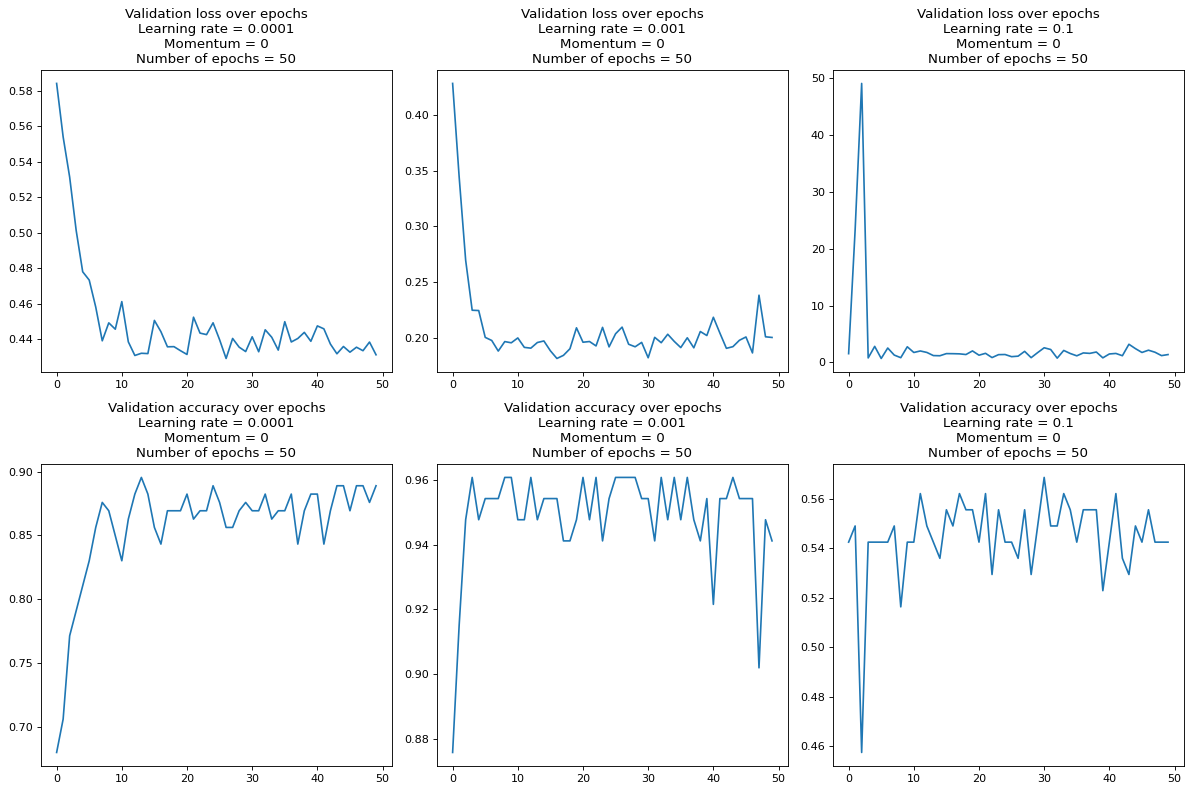

In [ ]:
plt.figure(figsize=(15, 10),dpi=80,tight_layout=True) # to specify width and height of the figure; tight_layout ensures proper spacing between adjacent subplots
plt.tight_layout()
i=1
for lr in learning_rates:
  model_ft1 = copy.deepcopy(model_ft) # deep copy was done as the NN model is same; only the training parameters will be changed
  momentum = 0
  epochs = 50

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft1.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  pltTitle = '\nLearning rate = ' + str(lr) + '\nMomentum = ' + str(momentum) + '\nNumber of epochs = ' + str(epochs)

  # plot Validation loss vs epoch number
  pltTitle1 = 'Validation loss over epochs' + pltTitle
  ax1 = plt.subplot(2, len(learning_rates), i)
  ax1.set_title(pltTitle1)

  # plot Validation accuracy vs epoch number
  pltTitle2 = 'Validation accuracy over epochs' + pltTitle
  ax2 = plt.subplot(2, len(learning_rates), i+3)
  ax2.set_title(pltTitle2)

  i=i+1
  
  model_ft1, best_acc, val_loss_over_epochs, val_acc_over_epochs  = train_model(model_ft1, criterion, optimizer_ft, exp_lr_scheduler,epochs)
  
  # plot validation loss and accuracy for every training epochs
  ax1.plot(val_loss_over_epochs)
  ax1.xlabel('Epoch number')
  ax1.ylabel('Validation loss')

  ax2.plot(val_acc_over_epochs)
  ax2.xlabel('Epoch number')
  ax2.ylabel('Validation accuracy')
  
plt.show()

**Observations:**


1.   For vary small learning rate 0.0001, the convergence is achieved within desirable tolerance approximately after 30 iterations.
2.   For medium learning rate of 0.001, the convergence was achieved approximately after 10 iterations.
3. If the learning rate is too high, e.g. 0.1, we got very less model accuracy of ~50 %. Also, we can see too many oscillations which indicates instability in convergence process.



**Conclusion:**
Learning rate should not too small or too large.

### Effect of momentum

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5834 Acc: 0.6762
val Loss: 0.3693 Acc: 0.9085

Epoch 1/49
----------
train Loss: 0.4742 Acc: 0.7828
val Loss: 0.3090 Acc: 0.8889

Epoch 2/49
----------
train Loss: 0.4315 Acc: 0.8443
val Loss: 0.2376 Acc: 0.9281

Epoch 3/49
----------
train Loss: 0.4316 Acc: 0.7746
val Loss: 0.2087 Acc: 0.9412

Epoch 4/49
----------
train Loss: 0.4348 Acc: 0.7828
val Loss: 0.1987 Acc: 0.9412

Epoch 5/49
----------
train Loss: 0.4078 Acc: 0.8279
val Loss: 0.1736 Acc: 0.9608

Epoch 6/49
----------
train Loss: 0.3637 Acc: 0.8279
val Loss: 0.1781 Acc: 0.9542

Epoch 7/49
----------
train Loss: 0.3105 Acc: 0.8770
val Loss: 0.1763 Acc: 0.9542

Epoch 8/49
----------
train Loss: 0.4083 Acc: 0.7951
val Loss: 0.1699 Acc: 0.9542

Epoch 9/49
----------
train Loss: 0.4129 Acc: 0.8197
val Loss: 0.1767 Acc: 0.9542

Epoch 10/49
----------
train Loss: 0.3616 Acc: 0.8443
val Loss: 0.1993 Acc: 0.9216

Epoch 11/49
----------
train Loss: 0.2878 Acc: 0.8975
val Loss: 0.1639 Acc: 0.9542

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5755 Acc: 0.6967
val Loss: 0.3154 Acc: 0.9281

Epoch 1/49
----------
train Loss: 0.4510 Acc: 0.8033
val Loss: 0.2258 Acc: 0.9477

Epoch 2/49
----------
train Loss: 0.4551 Acc: 0.8033
val Loss: 0.2061 Acc: 0.9281

Epoch 3/49
----------
train Loss: 0.3623 Acc: 0.8361
val Loss: 0.1664 Acc: 0.9542

Epoch 4/49
----------
train Loss: 0.3362 Acc: 0.8566
val Loss: 0.1795 Acc: 0.9412

Epoch 5/49
----------
train Loss: 0.3779 Acc: 0.8156
val Loss: 0.1756 Acc: 0.9346

Epoch 6/49
----------
train Loss: 0.3139 Acc: 0.8811
val Loss: 0.1818 Acc: 0.9281

Epoch 7/49
----------
train Loss: 0.3709 Acc: 0.8279
val Loss: 0.1837 Acc: 0.9281

Epoch 8/49
----------
train Loss: 0.3230 Acc: 0.8320
val Loss: 0.2012 Acc: 0.9281

Epoch 9/49
----------
train Loss: 0.3426 Acc: 0.8402
val Loss: 0.2152 Acc: 0.9150

Epoch 10/49
----------
train Loss: 0.2657 Acc: 0.9057
val Loss: 0.1717 Acc: 0.9477

Epoch 11/49
----------
train Loss: 0.3070 Acc: 0.8770
val Loss: 0.1636 Acc: 0.9346

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4900 Acc: 0.7664
val Loss: 0.1803 Acc: 0.9216

Epoch 1/49
----------
train Loss: 0.5169 Acc: 0.8238
val Loss: 0.1783 Acc: 0.9477

Epoch 2/49
----------
train Loss: 0.6829 Acc: 0.7295
val Loss: 0.3646 Acc: 0.8301

Epoch 3/49
----------
train Loss: 0.5275 Acc: 0.7951
val Loss: 0.3605 Acc: 0.8693

Epoch 4/49
----------
train Loss: 0.4844 Acc: 0.7828
val Loss: 0.2305 Acc: 0.9281

Epoch 5/49
----------
train Loss: 0.5212 Acc: 0.8197
val Loss: 0.2814 Acc: 0.9085

Epoch 6/49
----------
train Loss: 0.4191 Acc: 0.8607
val Loss: 0.3645 Acc: 0.9085

Epoch 7/49
----------
train Loss: 0.3845 Acc: 0.8320
val Loss: 0.2822 Acc: 0.9150

Epoch 8/49
----------
train Loss: 0.3198 Acc: 0.9057
val Loss: 0.3442 Acc: 0.8758

Epoch 9/49
----------
train Loss: 0.4225 Acc: 0.8197
val Loss: 0.3000 Acc: 0.8954

Epoch 10/49
----------
train Loss: 0.2513 Acc: 0.8852
val Loss: 0.2910 Acc: 0.9216

Epoch 11/49
----------
train Loss: 0.4605 Acc: 0.8197
val Loss: 0.2688 Acc: 0.9281

Epoch 12/49
----------
t

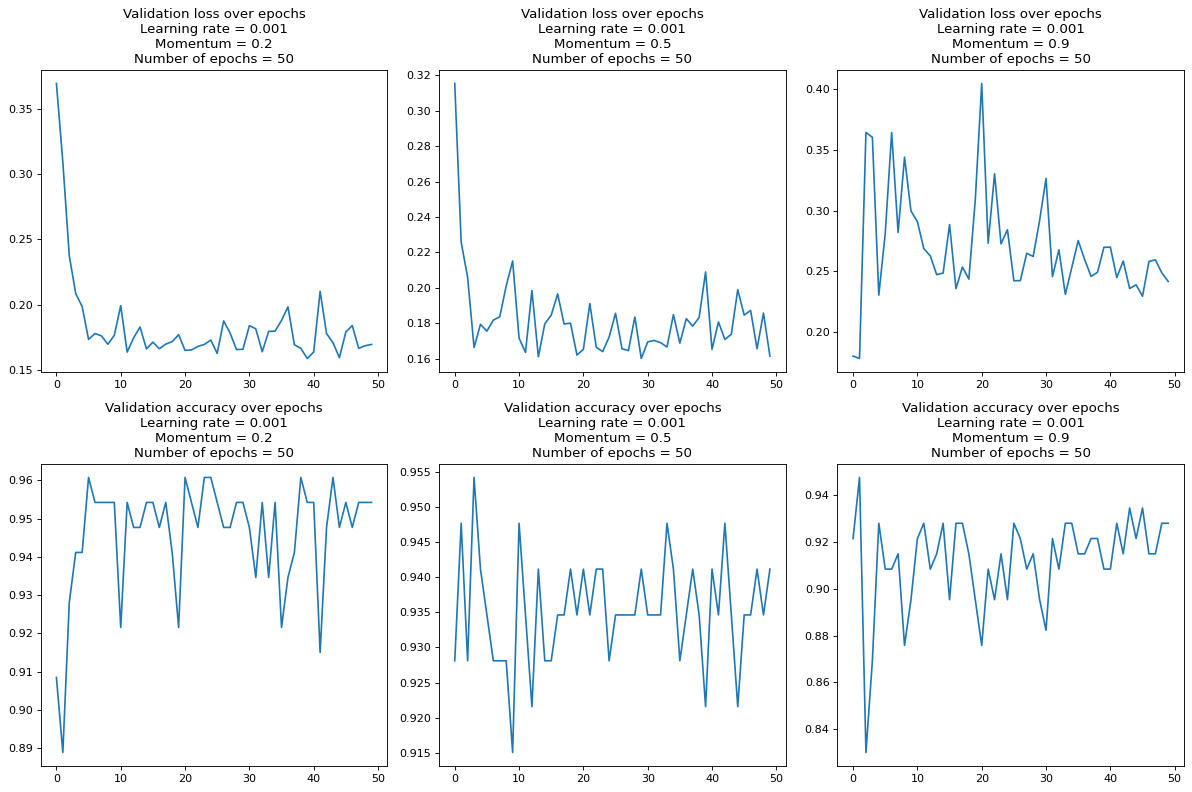

In [ ]:
plt.figure(figsize=(15, 10),dpi=80,tight_layout=True) # to specify width and height of the figure; tight_layout ensures proper spacing between adjacent subplots
plt.tight_layout()
i=1
for momentum in momentums:
  model_ft1 = copy.deepcopy(model_ft) # deep copy was done as the NN model is same; only the training parameters will be changed
  lr = 0.001
  epochs = 50

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft1.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  pltTitle = '\nLearning rate = ' + str(lr) + '\nMomentum = ' + str(momentum) + '\nNumber of epochs = ' + str(epochs)

  # plot Validation loss vs epoch number
  pltTitle1 = 'Validation loss over epochs' + pltTitle
  ax1 = plt.subplot(2, len(learning_rates), i)
  ax1.set_title(pltTitle1)

  # plot Validation accuracy vs epoch number
  pltTitle2 = 'Validation accuracy over epochs' + pltTitle
  ax2 = plt.subplot(2, len(learning_rates), i+3)
  ax2.set_title(pltTitle2)

  i=i+1
  
  # train model
  model_ft1, best_acc, val_loss_over_epochs, val_acc_over_epochs  = train_model(model_ft1, criterion, optimizer_ft, exp_lr_scheduler,epochs)
  
  # plot validation loss and accuracy for every training epochs
  ax1.plot(val_loss_over_epochs)
  ax1.xlabel('Epoch number')
  ax1.ylabel('Validation loss')

  ax2.plot(val_acc_over_epochs)
  ax2.xlabel('Epoch number')
  ax2.ylabel('Validation accuracy')
  
plt.show()

**Observations:**


1.   By increasing momentum from 0.2 to 0.5, we can see speed-up in convergence. The convergence is achieved in lesser number of iterations for momentum = 0.5
2.   If the momentum is too high for given learning rate, it causes instability in convergence which can be observed in 3rd plot shown above.




**Conclusion:**
Using some ammount of momentum certainly helps to achieve convergence faster. Although too much momentum is also not good.

We can also use some amount of dampening which can be specified in SGD in order to smoothen out the fluctuations

### Effect of number of epochs

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6305 Acc: 0.7295
val Loss: 0.2656 Acc: 0.9216

Epoch 1/9
----------
train Loss: 0.4981 Acc: 0.7992
val Loss: 0.3413 Acc: 0.8889

Epoch 2/9
----------
train Loss: 0.6775 Acc: 0.7500
val Loss: 0.7269 Acc: 0.8039

Epoch 3/9
----------
train Loss: 0.7602 Acc: 0.7213
val Loss: 0.4343 Acc: 0.8170

Epoch 4/9
----------
train Loss: 0.6543 Acc: 0.7541
val Loss: 0.7003 Acc: 0.8301

Epoch 5/9
----------
train Loss: 0.7690 Acc: 0.7541
val Loss: 0.7527 Acc: 0.7190

Epoch 6/9
----------
train Loss: 0.6987 Acc: 0.7664
val Loss: 0.3542 Acc: 0.8431

Epoch 7/9
----------
train Loss: 0.4007 Acc: 0.8443
val Loss: 0.3332 Acc: 0.8824

Epoch 8/9
----------
train Loss: 0.3150 Acc: 0.8934
val Loss: 0.3253 Acc: 0.8889

Epoch 9/9
----------
train Loss: 0.4354 Acc: 0.8279
val Loss: 0.2554 Acc: 0.9085

Training complete in 1m 1s
Best val Acc: 0.921569
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5565 Acc: 0.6803
val Loss: 0.1849 Acc: 0.9412

Epoch 1/49
----------
train Loss: 0.5399 Acc: 0.7746
val Loss: 0.3607 Acc: 0.8824

Epoch 2/49
----------
train Loss: 0.4877 Acc: 0.7951
val Loss: 0.3463 Acc: 0.8627

Epoch 3/49
----------
train Loss: 0.4652 Acc: 0.8197
val Loss: 0.2030 Acc: 0.9346

Epoch 4/49
----------
train Loss: 0.6770 Acc: 0.7623
val Loss: 0.4786 Acc: 0.8758

Epoch 5/49
----------
train Loss: 0.4608 Acc: 0.8484
val Loss: 0.3131 Acc: 0.8954

Epoch 6/49
----------
train Loss: 0.5414 Acc: 0.7705
val Loss: 0.2969 Acc: 0.9150

Epoch 7/49
----------
train Loss: 0.3487 Acc: 0.8607
val Loss: 0.2774 Acc: 0.9085

Epoch 8/49
----------
train Loss: 0.2790 Acc: 0.8852
val Loss: 0.2333 Acc: 0.9281

Epoch 9/49
----------
train Loss: 0.2335 Acc: 0.9057
val Loss: 0.2459 Acc: 0.9281

Epoch 10/49
----------
train Loss: 0.2899 Acc: 0.8730
val Loss: 0.2419 Acc: 0.9085

Epoch 11/49
----------
train Loss: 0.3227 Acc: 0.8648
val Loss: 0.2256 Acc: 0.9150

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6739 Acc: 0.6803
val Loss: 0.1939 Acc: 0.9281

Epoch 1/249
----------
train Loss: 0.5681 Acc: 0.7869
val Loss: 0.4466 Acc: 0.8301

Epoch 2/249
----------
train Loss: 0.5190 Acc: 0.8033
val Loss: 0.2286 Acc: 0.8954

Epoch 3/249
----------
train Loss: 0.5256 Acc: 0.7664
val Loss: 0.2697 Acc: 0.8758

Epoch 4/249
----------
train Loss: 0.3521 Acc: 0.8689
val Loss: 0.8941 Acc: 0.7124

Epoch 5/249
----------
train Loss: 0.7301 Acc: 0.7418
val Loss: 0.4463 Acc: 0.8562

Epoch 6/249
----------
train Loss: 0.4333 Acc: 0.8443
val Loss: 0.5739 Acc: 0.8170

Epoch 7/249
----------
train Loss: 0.4216 Acc: 0.8361
val Loss: 0.2700 Acc: 0.8889

Epoch 8/249
----------
train Loss: 0.3233 Acc: 0.8648
val Loss: 0.2951 Acc: 0.9216

Epoch 9/249
----------
train Loss: 0.3314 Acc: 0.8443
val Loss: 0.2755 Acc: 0.9150

Epoch 10/249
----------
train Loss: 0.3683 Acc: 0.8484
val Loss: 0.2298 Acc: 0.9216

Epoch 11/249
----------
train Loss: 0.2645 Acc: 0.8607
val Loss: 0.2118 Acc: 0.9281

Epoch 12/249


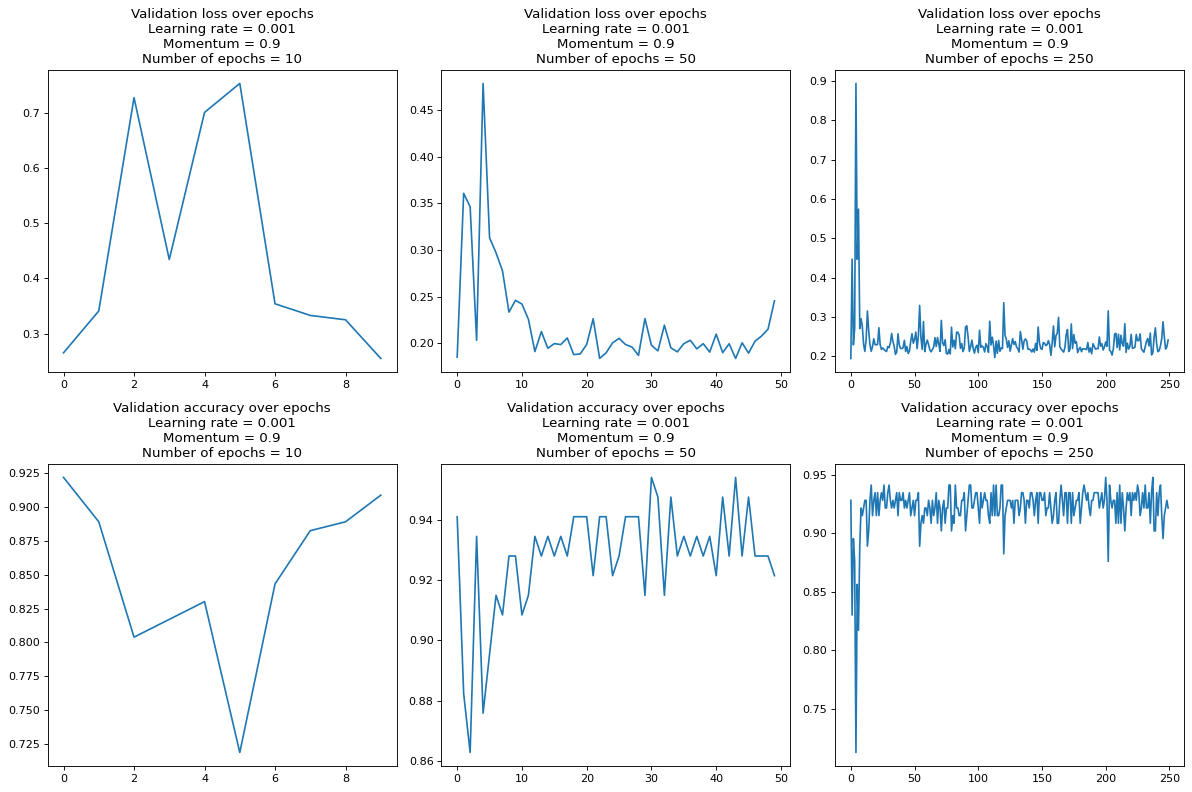

In [ ]:
plt.figure(figsize=(15, 10),dpi=80,tight_layout=True) # to specify width and height of the figure; tight_layout ensures proper spacing between adjacent subplots
plt.tight_layout()
i=1
for epochs in num_epochs:
  
  model_ft1 = copy.deepcopy(model_ft) # deep copy was done as the NN model is same; only the training parameters will be changed
  lr = 0.001
  momentum = 0.9

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft1.parameters(), lr=lr, momentum=momentum)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  pltTitle = '\nLearning rate = ' + str(lr) + '\nMomentum = ' + str(momentum) + '\nNumber of epochs = ' + str(epochs)

  # plot Validation loss vs epoch number
  pltTitle1 = 'Validation loss over epochs' + pltTitle
  ax1 = plt.subplot(2, len(learning_rates), i)
  ax1.set_title(pltTitle1)

  # plot Validation accuracy vs epoch number
  pltTitle2 = 'Validation accuracy over epochs' + pltTitle
  ax2 = plt.subplot(2, len(learning_rates), i+3)
  ax2.set_title(pltTitle2)

  i=i+1
  
  #train model
  model_ft1, best_acc, val_loss_over_epochs, val_acc_over_epochs  = train_model(model_ft1, criterion, optimizer_ft, exp_lr_scheduler,epochs)
  
  # plot validation loss and accuracy for every training epochs
  ax1.plot(val_loss_over_epochs)
  ax1.xlabel('Epoch number')
  ax1.ylabel('Validation loss')

  ax2.plot(val_acc_over_epochs)
  ax2.xlabel('Epoch number')
  ax2.ylabel('Validation accuracy')
  
plt.show()

**Observations**:



1. For lower number of epochs, the convergence is not acheived.

3. When number of epochs is too high, it will be time consuming to train for similar model accuracy.



**Conclusion:**
Number of epochs should not too large or too small. Instead we can use relative tolerance to check for convergence. This will stop the iterations in between which helps us to utilize computational resources optimally.

Ref:

[Creating multiple subplots using plt.subplots](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

# Q1 - Part e
Introduce weight decay (L2 penalty on weights) and find a good value for the weight
decay factor.

**Since the learning_rate = 0.001 and momentum=0.5 was found to be good in previous analysis, we are using these values in folowing code**

**The L2 penalty on weights (weight decay) is varied from 0 to 0.2 in steps of 0.02**

Lambda = 0.0
Epoch 0/49
----------
train Loss: 0.6357 Acc: 0.6270
val Loss: 0.3455 Acc: 0.8889

Epoch 1/49
----------
train Loss: 0.4540 Acc: 0.7951
val Loss: 0.2245 Acc: 0.9281

Epoch 2/49
----------
train Loss: 0.4570 Acc: 0.7746
val Loss: 0.1993 Acc: 0.9412

Epoch 3/49
----------
train Loss: 0.3493 Acc: 0.8607
val Loss: 0.1803 Acc: 0.9412

Epoch 4/49
----------
train Loss: 0.3819 Acc: 0.8361
val Loss: 0.1986 Acc: 0.9216

Epoch 5/49
----------
train Loss: 0.3722 Acc: 0.8361
val Loss: 0.1858 Acc: 0.9346

Epoch 6/49
----------
train Loss: 0.3969 Acc: 0.7910
val Loss: 0.1887 Acc: 0.9346

Epoch 7/49
----------
train Loss: 0.3049 Acc: 0.8730
val Loss: 0.1756 Acc: 0.9346

Epoch 8/49
----------
train Loss: 0.3173 Acc: 0.8689
val Loss: 0.1731 Acc: 0.9346

Epoch 9/49
----------
train Loss: 0.2902 Acc: 0.8852
val Loss: 0.1779 Acc: 0.9412

Epoch 10/49
----------
train Loss: 0.3146 Acc: 0.8525
val Loss: 0.1860 Acc: 0.9412

Epoch 11/49
----------
train Loss: 0.3112 Acc: 0.8689
val Loss: 0.1889 Ac

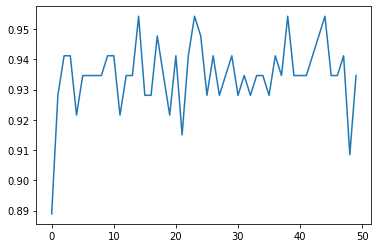

Lambda = 0.5
Epoch 0/49
----------
train Loss: 0.6672 Acc: 0.5656
val Loss: 0.3796 Acc: 0.8431

Epoch 1/49
----------
train Loss: 0.5093 Acc: 0.7336
val Loss: 0.3070 Acc: 0.9020

Epoch 2/49
----------
train Loss: 0.4766 Acc: 0.7705
val Loss: 0.2542 Acc: 0.9216

Epoch 3/49
----------
train Loss: 0.3937 Acc: 0.8320
val Loss: 0.2587 Acc: 0.9281

Epoch 4/49
----------
train Loss: 0.3967 Acc: 0.8279
val Loss: 0.2134 Acc: 0.9281

Epoch 5/49
----------
train Loss: 0.4113 Acc: 0.8156
val Loss: 0.2110 Acc: 0.9216

Epoch 6/49
----------
train Loss: 0.3499 Acc: 0.8566
val Loss: 0.2065 Acc: 0.9346

Epoch 7/49
----------
train Loss: 0.3686 Acc: 0.8689
val Loss: 0.2220 Acc: 0.9281

Epoch 8/49
----------
train Loss: 0.3468 Acc: 0.8607
val Loss: 0.2223 Acc: 0.9281

Epoch 9/49
----------
train Loss: 0.3201 Acc: 0.8607
val Loss: 0.2126 Acc: 0.9281

Epoch 10/49
----------
train Loss: 0.3610 Acc: 0.8443
val Loss: 0.2029 Acc: 0.9281

Epoch 11/49
----------
train Loss: 0.3582 Acc: 0.8238
val Loss: 0.2028 Ac

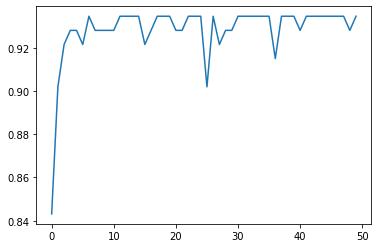

Lambda = 1.0
Epoch 0/49
----------
train Loss: 0.6688 Acc: 0.5779
val Loss: 0.3941 Acc: 0.8824

Epoch 1/49
----------
train Loss: 0.4929 Acc: 0.7582
val Loss: 0.3535 Acc: 0.9020

Epoch 2/49
----------
train Loss: 0.4922 Acc: 0.7541
val Loss: 0.3073 Acc: 0.9281

Epoch 3/49
----------
train Loss: 0.4814 Acc: 0.8115
val Loss: 0.2921 Acc: 0.9412

Epoch 4/49
----------
train Loss: 0.4216 Acc: 0.8320
val Loss: 0.2876 Acc: 0.9216

Epoch 5/49
----------
train Loss: 0.4089 Acc: 0.8320
val Loss: 0.2613 Acc: 0.9412

Epoch 6/49
----------
train Loss: 0.3648 Acc: 0.8852
val Loss: 0.2750 Acc: 0.9412

Epoch 7/49
----------
train Loss: 0.3963 Acc: 0.8443
val Loss: 0.2485 Acc: 0.9412

Epoch 8/49
----------
train Loss: 0.4054 Acc: 0.8320
val Loss: 0.2483 Acc: 0.9346

Epoch 9/49
----------
train Loss: 0.3637 Acc: 0.8852
val Loss: 0.2517 Acc: 0.9412

Epoch 10/49
----------
train Loss: 0.3934 Acc: 0.8607
val Loss: 0.2286 Acc: 0.9412

Epoch 11/49
----------
train Loss: 0.3793 Acc: 0.8566
val Loss: 0.2494 Ac

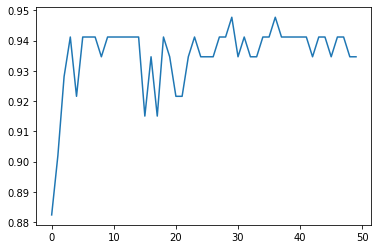

Lambda = 1.5
Epoch 0/49
----------
train Loss: 0.6285 Acc: 0.6475
val Loss: 0.4037 Acc: 0.9281

Epoch 1/49
----------
train Loss: 0.4898 Acc: 0.8197
val Loss: 0.3724 Acc: 0.9085

Epoch 2/49
----------
train Loss: 0.4946 Acc: 0.7951
val Loss: 0.3335 Acc: 0.9281

Epoch 3/49
----------
train Loss: 0.4472 Acc: 0.8279
val Loss: 0.3646 Acc: 0.9020

Epoch 4/49
----------
train Loss: 0.4292 Acc: 0.8566
val Loss: 0.3589 Acc: 0.9150

Epoch 5/49
----------
train Loss: 0.4472 Acc: 0.8525
val Loss: 0.3540 Acc: 0.9085

Epoch 6/49
----------
train Loss: 0.3948 Acc: 0.8730
val Loss: 0.3571 Acc: 0.9150

Epoch 7/49
----------
train Loss: 0.4040 Acc: 0.8484
val Loss: 0.3179 Acc: 0.9085

Epoch 8/49
----------
train Loss: 0.3903 Acc: 0.8975
val Loss: 0.3123 Acc: 0.9150

Epoch 9/49
----------
train Loss: 0.4115 Acc: 0.8525
val Loss: 0.3119 Acc: 0.9150

Epoch 10/49
----------
train Loss: 0.4113 Acc: 0.8525
val Loss: 0.3034 Acc: 0.9216

Epoch 11/49
----------
train Loss: 0.4142 Acc: 0.8689
val Loss: 0.3084 Ac

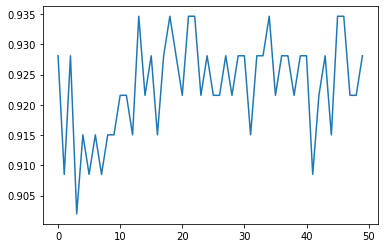

Lambda = 2.0
Epoch 0/49
----------
train Loss: 0.6314 Acc: 0.6311
val Loss: 0.4781 Acc: 0.8627

Epoch 1/49
----------
train Loss: 0.4968 Acc: 0.7746
val Loss: 0.4474 Acc: 0.8627

Epoch 2/49
----------
train Loss: 0.4845 Acc: 0.8279
val Loss: 0.4051 Acc: 0.9020

Epoch 3/49
----------
train Loss: 0.4800 Acc: 0.8238
val Loss: 0.4245 Acc: 0.8758

Epoch 4/49
----------
train Loss: 0.5007 Acc: 0.8197
val Loss: 0.4376 Acc: 0.8824

Epoch 5/49
----------
train Loss: 0.5127 Acc: 0.8033
val Loss: 0.4554 Acc: 0.8954

Epoch 6/49
----------
train Loss: 0.4801 Acc: 0.8607
val Loss: 0.5108 Acc: 0.8431

Epoch 7/49
----------
train Loss: 0.4853 Acc: 0.8689
val Loss: 0.4390 Acc: 0.9020

Epoch 8/49
----------
train Loss: 0.4952 Acc: 0.8566
val Loss: 0.4429 Acc: 0.9020

Epoch 9/49
----------
train Loss: 0.5159 Acc: 0.8320
val Loss: 0.4349 Acc: 0.9412

Epoch 10/49
----------
train Loss: 0.5151 Acc: 0.8566
val Loss: 0.4323 Acc: 0.9216

Epoch 11/49
----------
train Loss: 0.5032 Acc: 0.8689
val Loss: 0.4399 Ac

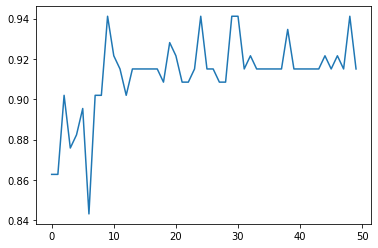

Lambda = 2.5
Epoch 0/49
----------
train Loss: 0.6791 Acc: 0.5697
val Loss: 0.5696 Acc: 0.7059

Epoch 1/49
----------
train Loss: 0.5576 Acc: 0.7500
val Loss: 0.5185 Acc: 0.8301

Epoch 2/49
----------
train Loss: 0.5525 Acc: 0.7705
val Loss: 0.5070 Acc: 0.8693

Epoch 3/49
----------
train Loss: 0.5224 Acc: 0.7910
val Loss: 0.5129 Acc: 0.8627

Epoch 4/49
----------
train Loss: 0.5198 Acc: 0.8361
val Loss: 0.5240 Acc: 0.8301

Epoch 5/49
----------
train Loss: 0.5367 Acc: 0.8320
val Loss: 0.5609 Acc: 0.8497

Epoch 6/49
----------
train Loss: 0.6046 Acc: 0.7869
val Loss: 0.6355 Acc: 0.7255

Epoch 7/49
----------
train Loss: 0.6351 Acc: 0.8074
val Loss: 0.6145 Acc: 0.8170

Epoch 8/49
----------
train Loss: 0.6498 Acc: 0.7090
val Loss: 0.6010 Acc: 0.8431

Epoch 9/49
----------
train Loss: 0.6487 Acc: 0.7541
val Loss: 0.6183 Acc: 0.8235

Epoch 10/49
----------
train Loss: 0.6555 Acc: 0.7377
val Loss: 0.6211 Acc: 0.8235

Epoch 11/49
----------
train Loss: 0.6589 Acc: 0.7500
val Loss: 0.6342 Ac

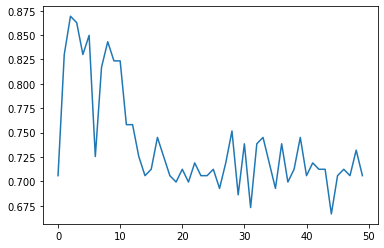

Lambda = 3.0
Epoch 0/49
----------
train Loss: 0.6929 Acc: 0.5656
val Loss: 0.5681 Acc: 0.8431

Epoch 1/49
----------
train Loss: 0.5584 Acc: 0.7828
val Loss: 0.5394 Acc: 0.9085

Epoch 2/49
----------
train Loss: 0.5574 Acc: 0.7869
val Loss: 0.5575 Acc: 0.8431

Epoch 3/49
----------
train Loss: 0.5398 Acc: 0.8033
val Loss: 0.5720 Acc: 0.8431

Epoch 4/49
----------
train Loss: 0.5787 Acc: 0.8361
val Loss: 0.6178 Acc: 0.8039

Epoch 5/49
----------
train Loss: 0.6261 Acc: 0.7992
val Loss: 0.6762 Acc: 0.8039

Epoch 6/49
----------
train Loss: 0.6891 Acc: 0.6598
val Loss: 0.6931 Acc: 0.4641

Epoch 7/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 8/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 9/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 10/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 11/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6932 Ac

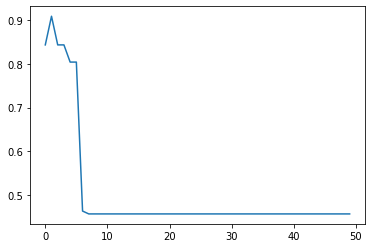

Lambda = 3.5
Epoch 0/49
----------
train Loss: 0.6596 Acc: 0.5984
val Loss: 0.5879 Acc: 0.7778

Epoch 1/49
----------
train Loss: 0.5744 Acc: 0.7828
val Loss: 0.5832 Acc: 0.8497

Epoch 2/49
----------
train Loss: 0.5488 Acc: 0.8156
val Loss: 0.6123 Acc: 0.7516

Epoch 3/49
----------
train Loss: 0.5884 Acc: 0.7623
val Loss: 0.6397 Acc: 0.7582

Epoch 4/49
----------
train Loss: 0.6366 Acc: 0.7951
val Loss: 0.6864 Acc: 0.5882

Epoch 5/49
----------
train Loss: 0.6919 Acc: 0.5205
val Loss: 0.6932 Acc: 0.4575

Epoch 6/49
----------
train Loss: 0.6932 Acc: 0.4631
val Loss: 0.6933 Acc: 0.4575

Epoch 7/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6933 Acc: 0.4575

Epoch 8/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6933 Acc: 0.4575

Epoch 9/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6933 Acc: 0.4575

Epoch 10/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6933 Acc: 0.4575

Epoch 11/49
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6933 Ac

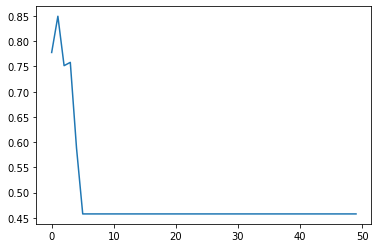

Lambda = 4.0
Epoch 0/49
----------
train Loss: 0.6423 Acc: 0.6434
val Loss: 0.6039 Acc: 0.8170

Epoch 1/49
----------
train Loss: 0.5744 Acc: 0.7746
val Loss: 0.6193 Acc: 0.8170

Epoch 2/49
----------
train Loss: 0.5902 Acc: 0.7992
val Loss: 0.6430 Acc: 0.7712

Epoch 3/49
----------
train Loss: 0.6140 Acc: 0.8115
val Loss: 0.6778 Acc: 0.6993

Epoch 4/49
----------
train Loss: 0.6826 Acc: 0.6516
val Loss: 0.6930 Acc: 0.5425

Epoch 5/49
----------
train Loss: 0.6933 Acc: 0.4016
val Loss: 0.6932 Acc: 0.4575

Epoch 6/49
----------
train Loss: 0.6932 Acc: 0.4631
val Loss: 0.6932 Acc: 0.4575

Epoch 7/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 8/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 9/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 10/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 11/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Ac

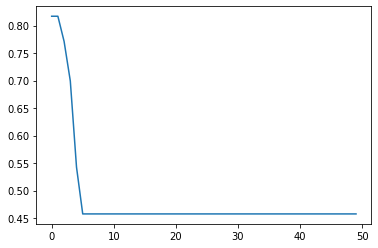

Lambda = 4.5
Epoch 0/49
----------
train Loss: 0.6757 Acc: 0.5861
val Loss: 0.6630 Acc: 0.5686

Epoch 1/49
----------
train Loss: 0.5956 Acc: 0.7459
val Loss: 0.6640 Acc: 0.6471

Epoch 2/49
----------
train Loss: 0.6068 Acc: 0.8320
val Loss: 0.6779 Acc: 0.5752

Epoch 3/49
----------
train Loss: 0.6654 Acc: 0.7664
val Loss: 0.6930 Acc: 0.4575

Epoch 4/49
----------
train Loss: 0.6932 Acc: 0.5205
val Loss: 0.6933 Acc: 0.4575

Epoch 5/49
----------
train Loss: 0.6933 Acc: 0.4877
val Loss: 0.6931 Acc: 0.5425

Epoch 6/49
----------
train Loss: 0.6933 Acc: 0.4713
val Loss: 0.6932 Acc: 0.4575

Epoch 7/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 8/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 9/49
----------
train Loss: 0.6932 Acc: 0.4713
val Loss: 0.6932 Acc: 0.4575

Epoch 10/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Acc: 0.4575

Epoch 11/49
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6932 Ac

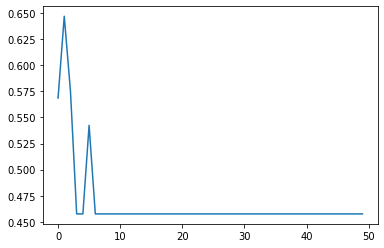

In [35]:
decays = np.arange(0,5,0.5)
val_acc_history = np.zeros(len(decays))
i=0
for weight_decay in decays:
  print('Lambda = ' + str(weight_decay))
  model_ft1 = copy.deepcopy(model_ft)
  epochs = 50

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft1.parameters(), lr=0.001, momentum=0.5,weight_decay=weight_decay)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  # train the model
  model_ft1, best_acc, val_loss_over_epochs, val_acc_over_epochs  = train_model(model_ft1, criterion, optimizer_ft, exp_lr_scheduler,epochs)
  plt.plot(val_acc_over_epochs)
  plt.show()

  # store the best validation accuracy in an array for further plotting to choose optimum weight decay
  val_acc_history[i] = best_acc
  i=i+1

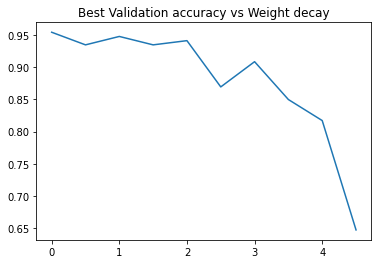

In [37]:
# plot Best validation accuracy for different values of weight
plt.plot(decays,val_acc_history)
plt.title('Best Validation accuracy vs Weight decay')
plt.show()

**Observations:**
For weight decay = 0, we got maximum validation accuracy. So, the optimum value of weight decay = 0.

# Train model one last time for optimum hyperparameters

In [14]:
# optimum hyperparameters
lr = 0.001
momentum = 0.5
weight_decay = 0
num_epochs = 50

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train the model
model_ft, best_acc, val_loss_over_epochs, val_acc_over_epochs  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs)

Epoch 0/49
----------
train Loss: 0.3107 Acc: 0.8566
val Loss: 0.1686 Acc: 0.9216

Epoch 1/49
----------
train Loss: 0.2893 Acc: 0.8607
val Loss: 0.1673 Acc: 0.9412

Epoch 2/49
----------
train Loss: 0.3001 Acc: 0.8730
val Loss: 0.1699 Acc: 0.9346

Epoch 3/49
----------
train Loss: 0.3469 Acc: 0.8525
val Loss: 0.1977 Acc: 0.9150

Epoch 4/49
----------
train Loss: 0.4086 Acc: 0.8074
val Loss: 0.1914 Acc: 0.9216

Epoch 5/49
----------
train Loss: 0.3058 Acc: 0.8648
val Loss: 0.1627 Acc: 0.9346

Epoch 6/49
----------
train Loss: 0.3294 Acc: 0.8484
val Loss: 0.1732 Acc: 0.9412

Epoch 7/49
----------
train Loss: 0.2434 Acc: 0.8934
val Loss: 0.1880 Acc: 0.9150

Epoch 8/49
----------
train Loss: 0.2664 Acc: 0.8730
val Loss: 0.1711 Acc: 0.9281

Epoch 9/49
----------
train Loss: 0.3522 Acc: 0.8197
val Loss: 0.1700 Acc: 0.9281

Epoch 10/49
----------
train Loss: 0.2708 Acc: 0.8770
val Loss: 0.1705 Acc: 0.9216

Epoch 11/49
----------
train Loss: 0.3024 Acc: 0.8689
val Loss: 0.1895 Acc: 0.9216

Ep

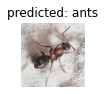

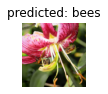

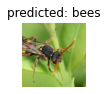

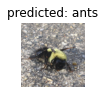

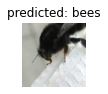

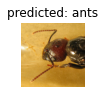

In [16]:
# visualize model for few examples
visualize_model(model_ft)